In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy import ndimage
from PIL import Image


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [6]:
image_size = 28 # Pixel width and height.
size = image_size,image_size
pixel_depth = 255.0 # Number of levels per pixel.
sizes = [784,622,222,473]
folders = [
    r'data2//Arms//',
    r'data2//Figure_normal_legs//',
    r'data2//FigureWheels//',
    r'data2//Head//',
]

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      img = Image.open(image_file)
      newImg = img.resize(size, Image.ANTIALIAS)
      image_data = (np.array(newImg).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

X_datasets = list()
print(X_datasets)
Y_datasets = list()
for idx in range(len(folders)):
    folder = folders[idx] 
    X_datasets.append(load_letter(folder, sizes[idx]))
    labels = np.zeros((X_datasets[-1].shape[0],len(folders)))
    labels[:,idx] = 1
    Y_datasets.append(labels)
    

[]
data2//Arms//
Full dataset tensor: (784, 28, 28)
Mean: 0.112809
Standard deviation: 0.143145
data2//Figure_normal_legs//
Full dataset tensor: (622, 28, 28)
Mean: 0.0883994
Standard deviation: 0.16318
data2//FigureWheels//
Full dataset tensor: (222, 28, 28)
Mean: 0.075104
Standard deviation: 0.165659
data2//Head//
Full dataset tensor: (473, 28, 28)
Mean: 0.0372736
Standard deviation: 0.201234


Total samples number: (2101, 28, 28)
Samples for tests: 526
Samples for trains: 1575


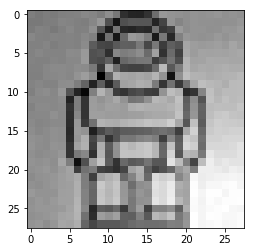

In [7]:
from sklearn.model_selection import train_test_split

X_datasets2 = np.concatenate(X_datasets)
Y_datasets2 = np.concatenate(Y_datasets)
print("Total samples number:",X_datasets2.shape)
X_trains,X_tests,Y_trains,Y_tests = train_test_split(X_datasets2,Y_datasets2,test_size=0.25)
print("Samples for tests:",Y_tests.shape[0])
print("Samples for trains:",Y_trains.shape[0])
plt.imshow(X_tests[0],cmap='gray')

In [8]:
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Reshape
from keras.callbacks import EarlyStopping,ModelCheckpoint
import numpy

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.00001, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(filepath='./weights.net', verbose=1, save_best_only=True),
    
]

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

input_dim = X_trains[0].shape[0]*X_trains[0].shape[1]
print((X_trains[0].shape[0],X_trains[0].shape[1]))
print(Y_trains[0].shape[0])
# create model
model = Sequential()
model.add(Reshape((input_dim,), input_shape=(X_trains[0].shape[0],X_trains[0].shape[1])))
model.add(Dense(input_dim, input_shape = (input_dim,), init='uniform', activation='relu'))
model.add(Dense(int(input_dim/2), init='uniform', activation='relu'))
model.add(Dense(int(input_dim), init='uniform', activation='relu'))
model.add(Dense(Y_trains[0].shape[0],init='uniform', name="output"))
model.add(Activation('softmax', name="softmax"))
model.summary()

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_trains, 
          Y_trains, 
          epochs=20, 
          batch_size=10, 
            )
# calculate predictions
results = model.evaluate(X_tests, Y_tests, batch_size=32, verbose=1, sample_weight=None)
# round predictions
print(results)

(28, 28)
4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_8 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_9 (Dense)              (None, 784)               308112    
_________________________________________________________________
output (Dense)               (None, 4)                 3140      
_________________________________________________________________
softmax (Activation)         (None, 4)                 0         
Total params: 1,234,412
Trainable params: 1,234,412
Non-trainable params: 0
_______________________________________________________

C:\Users\Assem\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(784, input_shape=(784,), activation="relu", kernel_initializer="uniform")`
C:\Users\Assem\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(392, activation="relu", kernel_initializer="uniform")`
C:\Users\Assem\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(784, activation="relu", kernel_initializer="uniform")`
C:\Users\Assem\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, name="output", kernel_initializer="uniform")`


Epoch 1/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.3075 - acc: 0.8725
Epoch 2/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.2112 - acc: 0.9141
Epoch 3/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.1645 - acc: 0.9354
Epoch 4/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.1173 - acc: 0.9567A: 0s - loss: 0.1206 - acc: 0
Epoch 5/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.0975 - acc: 0.9617A: 0s - loss: 0.0986 - a
Epoch 6/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.0749 - acc: 0.9714
Epoch 7/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.0739 - acc: 0.9741
Epoch 8/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.0784 - acc: 0.9722
Epoch 9/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.0633 - acc: 0.9778
Epoch 10/20
1575/1575 [==============================] - 5s 3ms/step - los

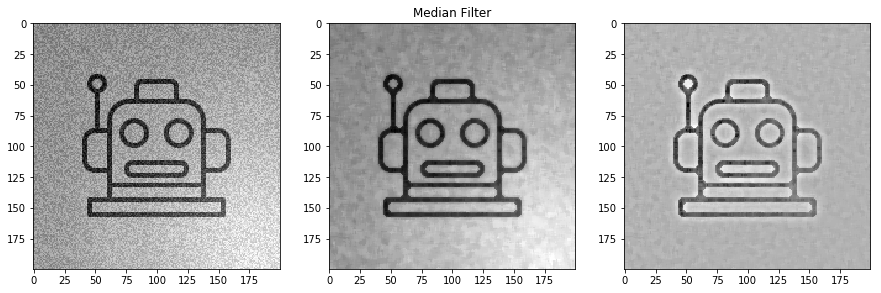

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy.ndimage.filters import median_filter
import numpy as np
from scipy import ndimage as ndimg
import math

%matplotlib inline
image = img.imread('./6.png')
fig = plt.figure(figsize=(15,10))
med = median_filter(image, size=5) #median filter
gaussed = ndimg.gaussian_filter(med, sigma=3)

#difference
Max = (med - gaussed).max()
Min = (med - gaussed).min()
res = np.log2(med) - np.log2(gaussed)
newImage = (res - Min) / (Max - Min)

plt.subplot('131')
plt.imshow(image, cmap='gray')
plt.subplot('132')
plt.imshow(med,cmap='gray')
plt.title('Median Filter')
plt.subplot('133')
plt.imshow(newImage,cmap='gray')

plt.show()